## Nifty Prediction using Recurrent Neural Networks


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
raw_data = pd.read_csv('^NSEI.csv', index_col='Date')

In [3]:
raw_data.index = pd.to_datetime(raw_data.index)

In [4]:
raw_data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-07-15,11614.750000,11617.299805,11532.500000,11588.349609,11588.349609,357700
2019-07-16,11596.650391,11670.000000,11574.200195,11662.599609,11662.599609,465800
2019-07-17,11670.750000,11706.599609,11651.700195,11687.500000,11687.500000,450900
2019-07-18,11675.599609,11676.799805,11582.400391,11596.900391,11596.900391,483400
2019-07-19,11627.950195,11639.900391,11400.349609,11419.250000,11419.250000,432600


### Data is cleaned and null values are removed. Also objects mapped to numeric values

In [5]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2922 entries, 2007-09-17 to 2019-07-19
Data columns (total 6 columns):
Open         2922 non-null object
High         2922 non-null object
Low          2922 non-null object
Close        2922 non-null object
Adj Close    2922 non-null object
Volume       2922 non-null object
dtypes: object(6)
memory usage: 159.8+ KB


In [6]:
raw_data = raw_data.drop(raw_data[raw_data['Adj Close']=='null'].index)

In [7]:
data = pd.to_numeric(raw_data['Adj Close']).to_frame()

### Nifty Index plot for last 12 years

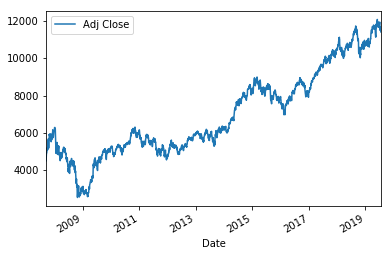

In [8]:
data.plot()

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2896 entries, 2007-09-17 to 2019-07-19
Data columns (total 1 columns):
Adj Close    2896 non-null float64
dtypes: float64(1)
memory usage: 45.2 KB


### Last one year data is split into train and test data

As needed latest data for testing, train_test_split is random and therefore not used for splitting

In [10]:
data = data.tail(252)
train_data = data.head(200)
test_data = data.tail(52)

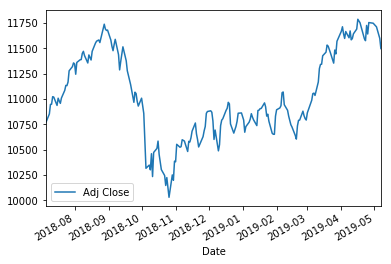

In [11]:
train_data.plot()

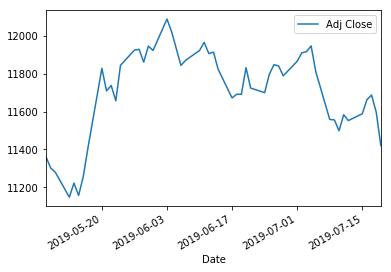

In [12]:
test_data.plot()

### Scaling the data ( Preprocessing )

In [13]:
from sklearn.preprocessing import MinMaxScaler

In [14]:
scalar = MinMaxScaler()

In [15]:
train_scaled = scalar.fit_transform(train_data.dropna())
test_scaled = scalar.transform(test_data.dropna())


### Setting up the RNN Model

In [16]:
import tensorflow as tf

In [17]:
sess = tf.InteractiveSession()

In [18]:
# Just one feature, the time series
num_inputs = 1
# Num of steps in each batch
num_time_steps = 52
# 100 neuron layer, play with this
num_neurons = 100

num_layers = 3

# Just one output, predicted time series
num_outputs = 1

## You can also try increasing iterations, but decreasing learning rate
# learning rate you can play with this
learning_rate = 0.001
# how many iterations to go through (training steps), you can play with this
num_train_iterations = 10000

# Size of the batch of data
batch_size = 1

**  Create Placeholders for X and y. We are training the RNN network to predict one point into the future based on the input sequence. **

In [19]:
X = tf.placeholder(tf.float64,[None,num_time_steps,num_inputs])
y = tf.placeholder(tf.float64,[None,num_time_steps,num_outputs])

** For creating RNN Layer various options can be play around OutputProjectionWrappers, BasicRNNCells, BasicLSTMCells, MultiRNNCell, GRUCell etc **

In [20]:
cell = tf.contrib.rnn.OutputProjectionWrapper(tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons,activation=tf.nn.relu),output_size=num_outputs)

In [21]:
#cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons,activation=tf.nn.relu)
#                                      for layer in range(num_layers)])

In [22]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float64)

### Loss Function and Optimizer

** Create a Mean Squared Error Loss Function and use it to minimize an AdamOptimizer with given learning rate. **

In [23]:
loss = tf.reduce_mean(tf.square(outputs - y)) # MSE

In [24]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

In [25]:
train = optimizer.minimize(loss)

In [26]:
init = tf.global_variables_initializer()

In [27]:
sess.run(init)

** Next Batch function takes the training data and selects time steps randomy to train the model **

** Return values are input X value and y outout value with +1 time step for fitting **

In [28]:
def next_batch(training_data,batch_size,steps):    
    
    # Grab a random starting point for each batch
    rand_start = np.random.randint(0,len(training_data)-steps) 

    # Create Y data for time series in the batches
    y_batch = np.array(training_data[rand_start:rand_start+steps+1]).reshape(1,steps+1).round(4)

    return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1) 

** Model is trained based on batches and number of iterations **

** Learning rate and iterations can be changed given above **

In [29]:
for iteration in range(num_train_iterations):
    
    X_batch, y_batch = next_batch(train_scaled, batch_size, num_time_steps)
    
    sess.run(train, feed_dict={X:X_batch, y:y_batch})
    
    if iteration%1000==0:
        print(iteration, "MSE", loss.eval(feed_dict={X:X_batch, y:y_batch}))
        

0 MSE 0.0743509931084093
1000 MSE 0.00543889853530285
2000 MSE 0.0030833703506012253
3000 MSE 0.0016823446850671357
4000 MSE 0.0021960863721810775
5000 MSE 0.002162827414355238
6000 MSE 0.002203948874072562
7000 MSE 0.0016243087028548764
8000 MSE 0.0008715645083878902
9000 MSE 0.0014401662887078583


** Model will be used to test the prediction in 2 ways : **

** 1) Test data will be true data for 52 days and model have to predict just next day ( Predicting Close 1 by 1 ) **

** 1) Test data will be replaced by predicted data one by one for 52 days ( Predicting Close ). In the end model will predict the next day only based on last 52 predicted values **


In [30]:
    # Create a numpy array for your genreative seed from the last 52 days of the 
    # training set data. 
    #Train seed will always have true values and have to only predict next day
    
    train_seed = list(train_scaled[-num_time_steps:])
    test_seed = []
    
    ## Now create a for loop that 
    for iteration in range(num_time_steps):
        X_batch = np.array(train_seed[-num_time_steps:]).reshape(1, num_time_steps, 1)
        y_pred_one = sess.run(outputs, feed_dict={X: X_batch})
        train_seed.append(test_scaled[-num_time_steps + iteration])
        test_seed.append(y_pred_one[0,-1,0])

In [31]:
    # Create a numpy array for your genreative seed from the last 52 days of the 
    # training set data. 
    #Train seed will only have predicted values to forcast next day value
    
    train_seed = list(train_scaled[-num_time_steps:])
    
    ## Now create a for loop that 
    for iteration in range(num_time_steps):
        X_batch = np.array(train_seed[-num_time_steps:]).reshape(1, num_time_steps, 1)
        y_pred_full = sess.run(outputs, feed_dict={X: X_batch})
        train_seed.append(np.array([y_pred_full.mean()]))

In [32]:
results_full = scalar.inverse_transform(np.array(train_seed[num_time_steps:]).reshape(num_time_steps,1))
results_one = scalar.inverse_transform(np.array(test_seed).reshape(num_time_steps,1))

In [33]:
test_data['Predicted Close'] = results_full
test_data['Predicted Close 1by1'] = results_one

C:\Users\LENOVO\Anaconda3\envs\tfdeeplearning\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\LENOVO\Anaconda3\envs\tfdeeplearning\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


** As Expected, when model only have to predict next day it is close to Nifty test data **

** But when it had to predict whole 52 days, it formed smooth curve but trend is in sync with Nifty data **

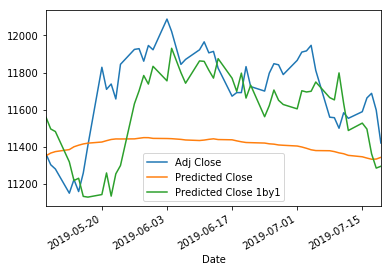

In [34]:
test_data.plot()